In [ ]:
import pylab as pl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [50]:
# crack the dataset open
df = pd.read_excel('data/Audatex_Claims.Updated(2021).xlsx')

df.columns, len(df.columns)

(Index(['CREATIONDATE', 'ASSESSMENTNUMBER', 'ORIGINATOR',
        'CLAIMREFERENCENUMBER', 'CLAIMNUMBER', 'WORKPROVIDER', 'BROKER',
        'CALCULATIONDATE', 'MANUFACTURERNAME', 'MODELNAME', 'SUBMODELTEXT',
        'YEARREG', 'MONTHREG', 'BODYCOLOUR', 'ODOMETER', 'NUMBERMODELOPTIONS',
        'ASSESSOR', 'REPAIRERNAME', 'USERSTATUS', 'AUTHSTATUS',
        'WARRANTYSTATUS', 'DAMAGESEVERITY', 'DRIVEABLE', 'INSUREDAMOUNT',
        'TOTALCOSTOFCLAIM', 'PARTSAMT', 'SUNDRYPARTSAMT', 'TOTALLABOURAMT',
        'TOTALPAINTLABOURCOST', 'TOTALPAINTMATERIALCOST', 'TOTALADDITIONALAMT',
        'BLOCKCODE', 'WASTECOLLECTIONTOTALAMT', 'LABOURHOURS', 'PAINTHOURS',
        'LABOURRATE', 'PAINTRATE', 'NUMBEROFPARTS', 'TYRECONDITION',
        'PREACCIDENTCONDITION', 'STEERINGCONDITION', 'BRAKES', 'IMPACTSOURCE',
        'IMPACTDES', 'JDENUMBER', 'SITEID', 'Insurer', 'Month', 'Year'],
       dtype='object'),
 49)

In [51]:
# basic exploration
print(df.info())  # check data types and missing values
print(df['TOTALCOSTOFCLAIM'].describe())  # summary stats for target
print(df.isnull().sum())  # check missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89450 entries, 0 to 89449
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CREATIONDATE             89450 non-null  datetime64[ns]
 1   ASSESSMENTNUMBER         89450 non-null  object        
 2   ORIGINATOR               89450 non-null  object        
 3   CLAIMREFERENCENUMBER     89449 non-null  object        
 4   CLAIMNUMBER              89449 non-null  object        
 5   WORKPROVIDER             89450 non-null  object        
 6   BROKER                   89141 non-null  object        
 7   CALCULATIONDATE          89450 non-null  datetime64[ns]
 8   MANUFACTURERNAME         89450 non-null  object        
 9   MODELNAME                89450 non-null  object        
 10  SUBMODELTEXT             89159 non-null  object        
 11  YEARREG                  89144 non-null  float64       
 12  MONTHREG                 89144 n

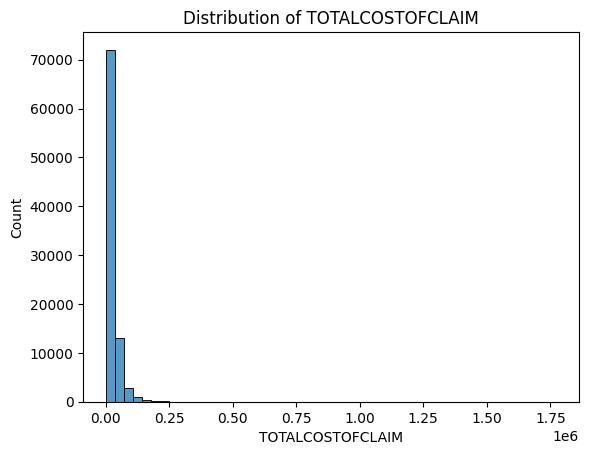

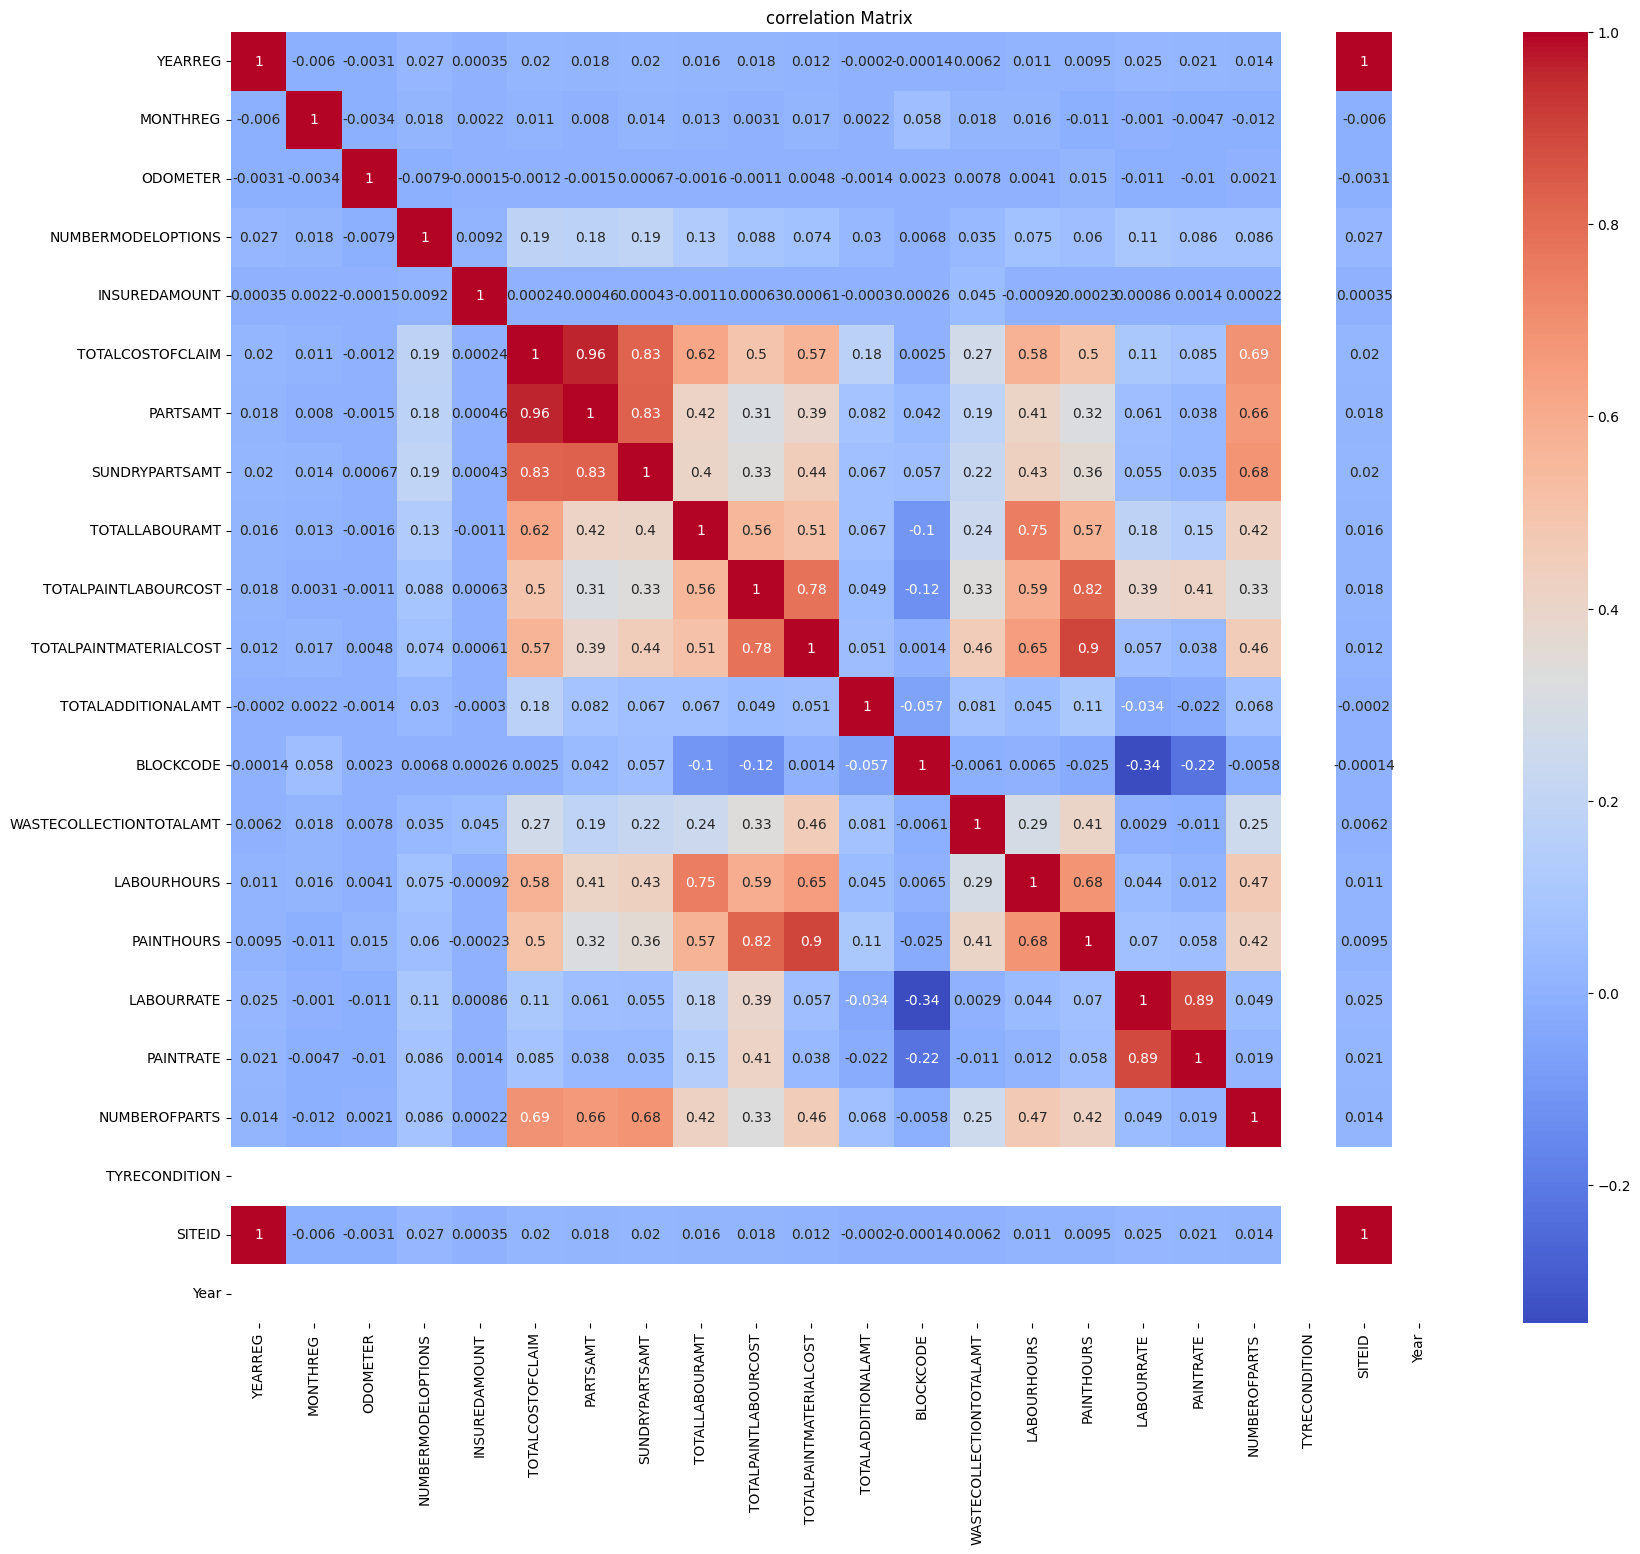

In [52]:
# visualize target distribution
sns.histplot(df['TOTALCOSTOFCLAIM'], bins=50)
pl.title('Distribution of TOTALCOSTOFCLAIM')
pl.show()

# correlation with numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
pl.title('correlation Matrix')
pl.subplots_adjust(right=2.5, top=2.8)
pl.show()

In [53]:
print(f'tyre condition column : {np.sum(df['TYRECONDITION'])}')

tyre condition column : 0.0


In [54]:
df['CREATIONDATE'] = pd.to_datetime(df['CREATIONDATE'])
df['CALCULATIONDATE'] = pd.to_datetime(df['CALCULATIONDATE'])
df['creation_year'] = df['CREATIONDATE'].dt.year
df['creation_month'] = df['CREATIONDATE'].dt.month
df['creation_day'] = df['CREATIONDATE'].dt.day
df['time_diff_days'] = (df['CALCULATIONDATE'] - df['CREATIONDATE']).dt.days

# drop original datetime columns
df = df.drop(['CREATIONDATE', 'CALCULATIONDATE'], axis=1)

Number of numerical columns: 21


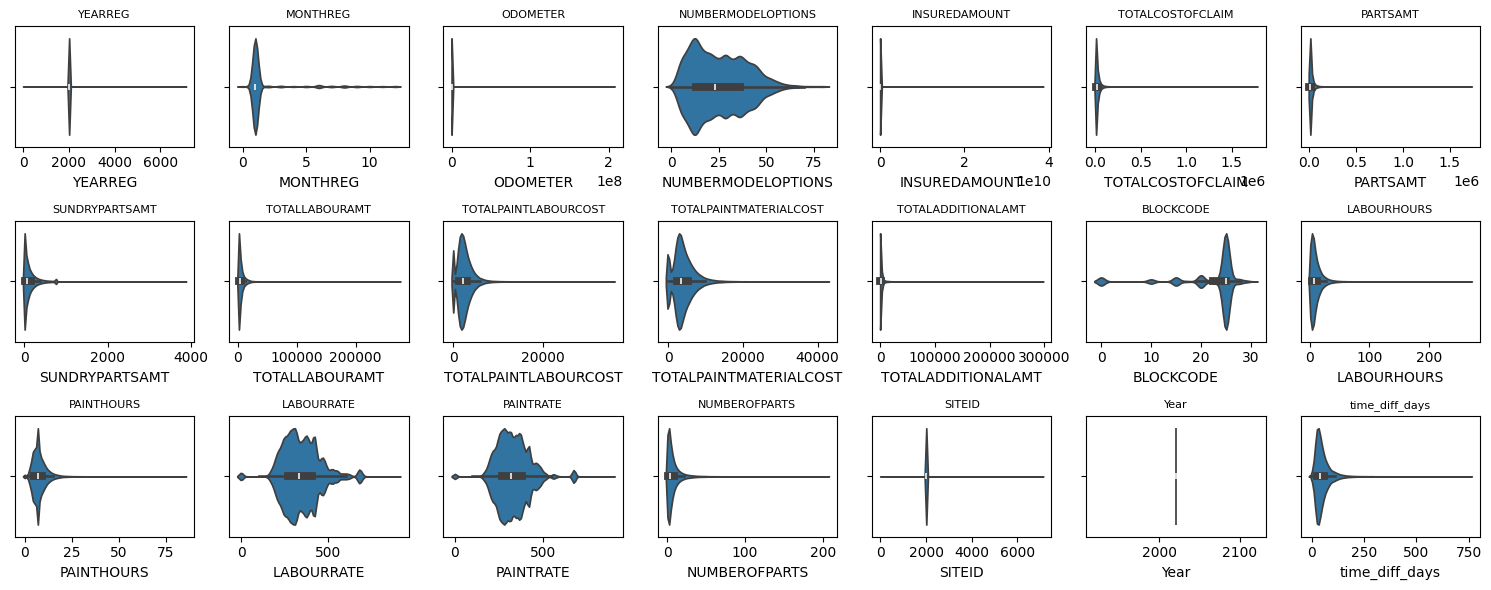

In [55]:

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# drop WASTECOLLECTIONTOTALAMT missing ~ 35 %
df = df.drop(['WASTECOLLECTIONTOTALAMT'], axis=1)

df = df.drop(['TYRECONDITION'], axis=1)   # this column is zero


# filter numerical columns for outlier visualization
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(f"Number of numerical columns: {len(numerical_cols)}")

# create subplots for numerical columns only
n_cols = 7  # Number of columns in the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate rows needed

fig, ax = pl.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 2))
ax = ax.flatten()  # Flatten the 2D array of axes for easier indexing

# plot violin plots for numerical columns
for i, col in enumerate(numerical_cols):
    sns.violinplot(x=df[col], orient='h', ax=ax[i])
    ax[i].set_title(col, fontsize=8)

# remove empty subplots if any
for i in range(len(numerical_cols), len(ax)):
    fig.delaxes(ax[i])

pl.tight_layout()
pl.show()

In [61]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# apply to numerical columns
for col in numerical_cols:
    original_len = len(df)
    df = remove_outliers(df, col)
    print(f"Removed {original_len - len(df)} outliers from {col}")

# check the new shape of the dataset
print(f"New dataset shape: {df.shape}")

Removed 1438 outliers from YEARREG
Removed 10812 outliers from MONTHREG
Removed 1956 outliers from ODOMETER
Removed 157 outliers from NUMBERMODELOPTIONS
Removed 4083 outliers from INSUREDAMOUNT
Removed 4672 outliers from TOTALCOSTOFCLAIM
Removed 2570 outliers from PARTSAMT
Removed 1197 outliers from SUNDRYPARTSAMT
Removed 4343 outliers from TOTALLABOURAMT
Removed 1654 outliers from TOTALPAINTLABOURCOST
Removed 1408 outliers from TOTALPAINTMATERIALCOST
Removed 4511 outliers from TOTALADDITIONALAMT
Removed 7586 outliers from BLOCKCODE
Removed 1597 outliers from LABOURHOURS
Removed 821 outliers from PAINTHOURS
Removed 220 outliers from LABOURRATE
Removed 86 outliers from PAINTRATE
Removed 1852 outliers from NUMBEROFPARTS
Removed 0 outliers from SITEID
Removed 0 outliers from Year
Removed 2265 outliers from time_diff_days
New dataset shape: (36222, 49)


Number of numerical columns: 21


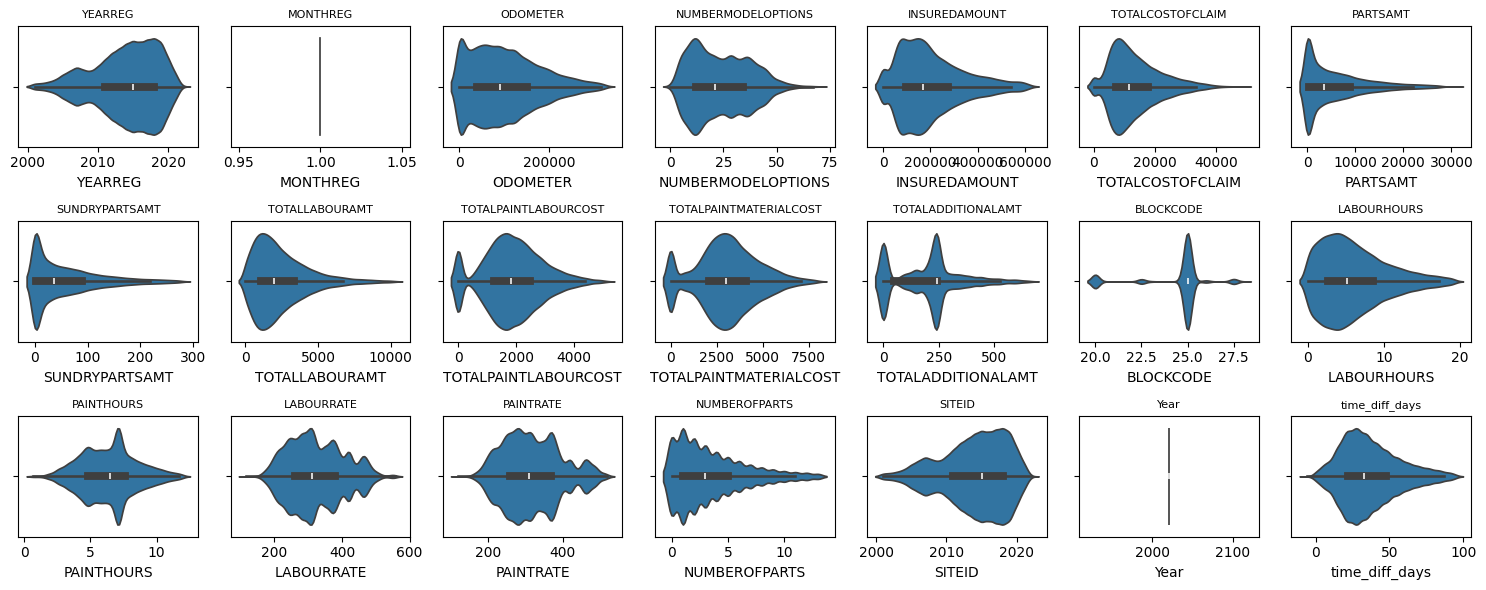

In [63]:
# filter numerical columns for outlier visualization
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(f"Number of numerical columns: {len(numerical_cols)}")

# create subplots for numerical columns only
n_cols = 7  # Number of columns in the subplot grid
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate rows needed

fig, ax = pl.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, n_rows * 2))
ax = ax.flatten()  # Flatten the 2D array of axes for easier indexing

# plot violin plots for numerical columns
for i, col in enumerate(numerical_cols):
    sns.violinplot(x=df[col], orient='h', ax=ax[i])
    ax[i].set_title(col, fontsize=8)

# remove empty subplots if any
for i in range(len(numerical_cols), len(ax)):
    fig.delaxes(ax[i])

pl.tight_layout()
pl.show()

In [67]:
# these are probably meaning less

df = df.drop(['MONTHREG', 'YEARREG', 'Year'], axis=1)

In [68]:

le = LabelEncoder()
for col in ['ASSESSMENTNUMBER', 'CLAIMREFERENCENUMBER', 'CLAIMNUMBER', 'JDENUMBER']:
    df[col] = le.fit_transform(df[col].astype(str))

# nne-hot encode remaining categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

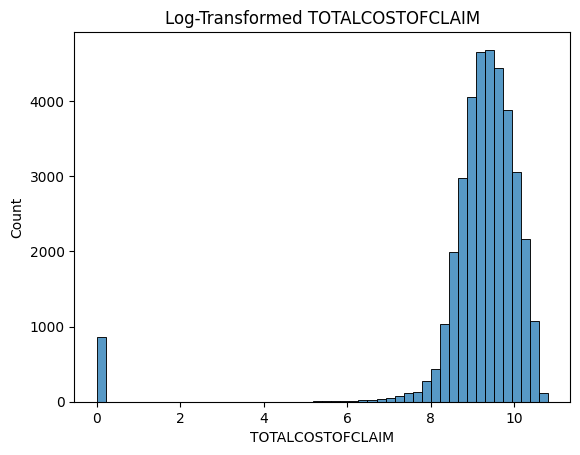

In [69]:
df['TOTALCOSTOFCLAIM'] = np.log1p(df['TOTALCOSTOFCLAIM'])

# visualize transformed-1
sns.histplot(df['TOTALCOSTOFCLAIM'], bins=50)
pl.title('Log-Transformed TOTALCOSTOFCLAIM')
pl.show()

In [81]:
scaler = StandardScaler()
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('TOTALCOSTOFCLAIM')
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [ ]:
X = df.drop('TOTALCOSTOFCLAIM', axis=1)
y = df['TOTALCOSTOFCLAIM']

X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [83]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)

cv_rmse_scores = cross_val_score(model, X, np.log1p(y), cv=5, scoring='neg_mean_squared_error')
cv_r2_scores = cross_val_score(model, X, np.log1p(y), cv=5, scoring='r2')


rmse_scores = np.sqrt(-cv_rmse_scores)

print(f"cross-validated RMSE scores: {rmse_scores}")
print(f"mean RMSE: {rmse_scores.mean():.2f} (+/- {rmse_scores.std() * 2:.2f})")
print(f"cross-validated R² scores: {cv_r2_scores}")
print(f"mean R²: {cv_r2_scores.mean():.2f} (+/- {cv_r2_scores.std() * 2:.2f})")

# optional: Fit on full dataset and predict on a holdout set for final evaluation

model.fit(X, np.log1p(y))
y_pred_log = model.predict(X)
y_pred_exp = np.expm1(y_pred_log)
y_exp = np.expm1(y)  # Reverse log transformation for the original target
final_rmse = np.sqrt(mean_squared_error(y_exp, y_pred_exp))
final_r2 = r2_score(y_exp, y_pred_exp)
print(f"final RMSE on full dataset: {final_rmse:.2f}")
print(f"final R² on full dataset: {final_r2:.2f}")

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/xola/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py", line 887, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.exceptions.DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>)


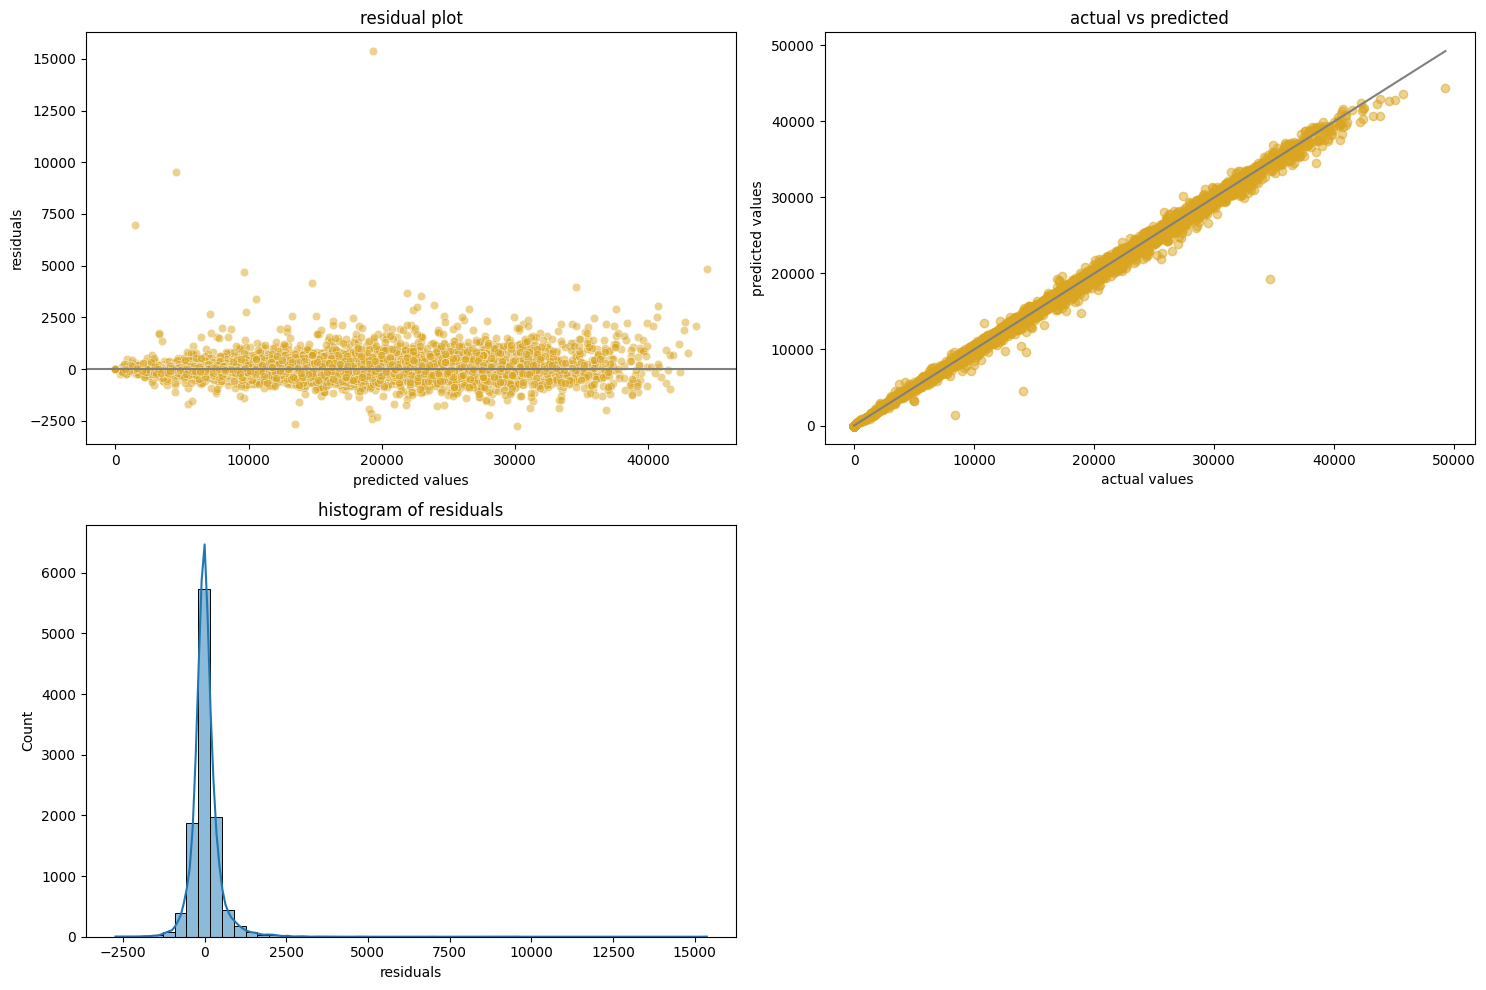

In [94]:
residuals = y_test_exp - y_pred_exp

fig, axes = pl.subplots(2, 2, figsize=(15, 10))

# Residual Plot
sns.scatterplot(x=y_pred_exp, y=residuals, alpha=0.5, color='goldenrod', ax=axes[0, 0])
axes[0, 0].axhline(y=0, color='grey', linestyle='-')
axes[0, 0].set_xlabel('predicted values')
axes[0, 0].set_ylabel('residuals')
axes[0, 0].set_title('residual plot')

# Actual vs Predicted
axes[0, 1].scatter(y_test_exp, y_pred_exp, alpha=0.5, color='goldenrod')
axes[0, 1].plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 
                color='grey', linestyle='-')
axes[0, 1].set_xlabel('actual values ')
axes[0, 1].set_ylabel('predicted values')
axes[0, 1].set_title('actual vs predicted')

# Histogram of Residuals
sns.histplot(residuals, bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('residuals')
axes[1, 0].set_title('histogram of residuals')

# # Boxplot of Residuals
# sns.boxplot(x=residuals, ax=axes[1, 1])
# axes[1, 1].set_xlabel('residuals')
# axes[1, 1].set_title('boxplot of residuals')

fig.delaxes(axes[1, 1])

pl.tight_layout()
pl.show()